In [1]:
# import necessary libraries

#https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#0
#he Explainable AI SDK and Copy Model to Deploy

#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures


from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

tf.__version__

'2.11.0'

In [2]:
#!gsutil cp gs://smart-ml-pongthorn/incident-train-data/TrainEval_Incident.csv data

In [69]:
cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour','response_to_resolved_hour']

unusedCols=['severity_id','severity_name','label_binary_severity']
labelCol='label_multi_severity'

model_dir='model'

# df['label_multi_severity'] =df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3}) 

In [70]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 return df
    
root_path='../../data'    
train = load_ml_data(f"{root_path}/train_incident.csv")
# val=train.copy()
val=load_ml_data(f"{root_path}/validation_incident.csv")
# test =val.copy()
test =load_ml_data(f"{root_path}/test_incident.csv")

labelList=list(train[labelCol].unique())
print(labelList)
nLabel=len(labelList)
print(f"No target label : {nLabel}")

# sr_predict=df.iloc[-1,:]
# df=df.iloc[0:len(df)-1,:]
                 
print(train.info())
train.tail()

[2, 0, 1, 3]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696 entries, 0 to 1695
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        1696 non-null   object 
 1   product_type               1696 non-null   object 
 2   brand                      1696 non-null   object 
 3   service_type               1696 non-null   object 
 4   incident_type              1696 non-null   object 
 5   open_to_close_hour         1696 non-null   float64
 6   response_to_resolved_hour  1696 non-null   float64
 7   label_multi_severity       1696 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 106.1+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity
1691,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Incident,Software,13.633333,0.833333,2
1692,24x7 4Hrs Response Time,Software,Veritas,Incident,General Incident,1.283333,1.000000,2
1693,24x7 4Hrs Resolution Time,Switch,Cisco,Incident,General Incident,484.750000,271.016667,1
1694,24x7 4Hrs Resolution Time,Hardware,Oracle,Incident,Hard Disk Drive Failure,25.833333,23.916667,2
1695,24x7 6Hrs Resolution Time,Software,VMWare,Incident,General Incident,1.416667,1.266667,2


In [71]:
def CalPctEachTargetClass(dfx):
    dfClassSummary=dfx.groupby([labelCol]).size().to_frame('No-Severity')
    dfClassSummary['Pct-Severity']= dfClassSummary['No-Severity']/dfClassSummary['No-Severity'].sum() *100
    dfClassSummary=dfClassSummary.round(0)
    return dfClassSummary
    




In [72]:
pctDF=CalPctEachTargetClass(train)
pctDF

,No-Severity,Pct-Severity
label_multi_severity,,
0,305,18.0
1,487,29.0
2,812,48.0
3,92,5.0


In [73]:
pctDF=CalPctEachTargetClass(val)
pctDF

,No-Severity,Pct-Severity
label_multi_severity,,
0,35,17.0
1,54,25.0
2,111,52.0
3,12,6.0


In [74]:
pdcDF=CalPctEachTargetClass(test)
pdcDF

,No-Severity,Pct-Severity
label_multi_severity,,
0,42,20.0
1,68,32.0
2,96,45.0
3,6,3.0


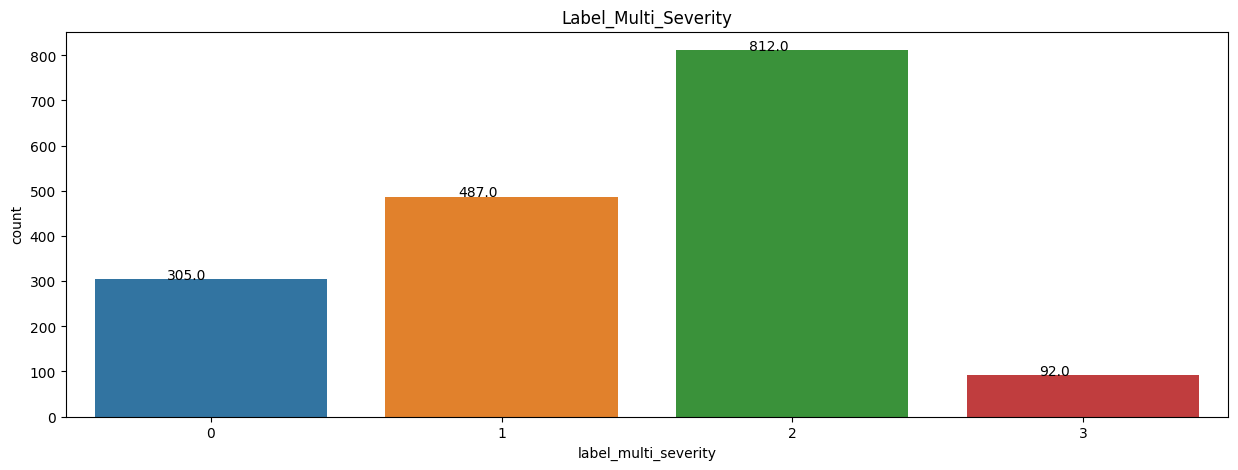

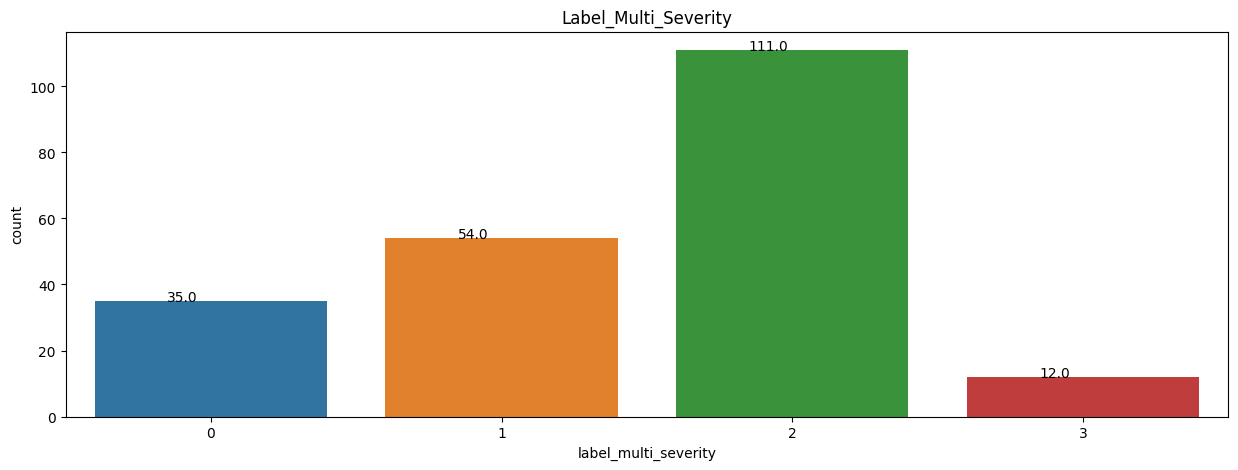

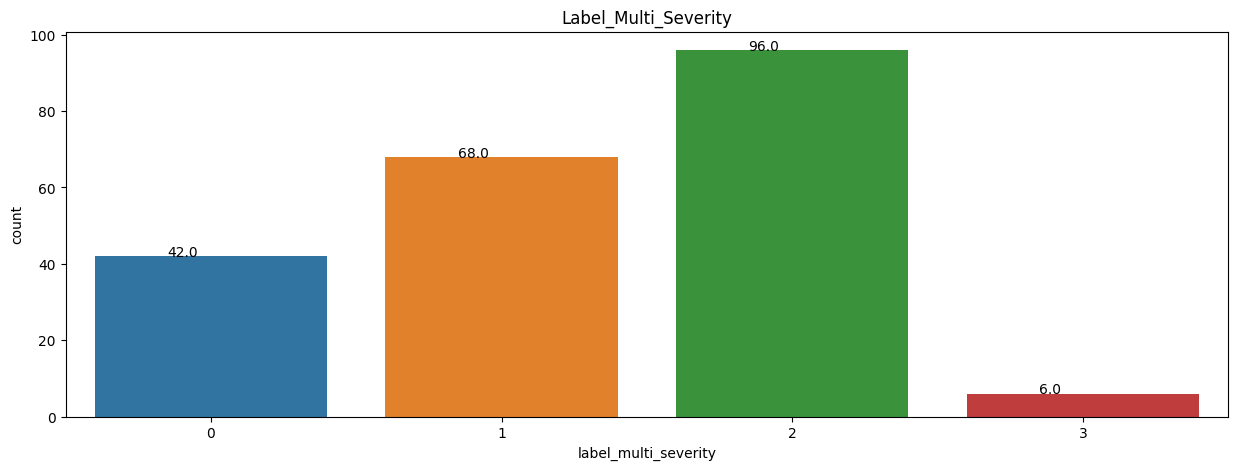

In [75]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=labelCol, data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol.title())
    plt.show()
    
plot_class(train)
plot_class(val)
plot_class(test)

In [ ]:
tf.keras.utils.to_categorical(train[labelCol], num_classes=nLabel)

In [76]:
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(train[l], num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [77]:
print("Explore Data from Tensor before keras data processing")
batch_size = 1
train_ds =multiple_label_df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print("========Features==========")
print('Every feature:', list(train_features.keys()))
print('product_type:', train_features['product_type'])
print('open_to_close_hour:', train_features['open_to_close_hour'])
print("========Labels==========")
print(f'{label_batch }')

Explore Data from Tensor before keras data processing
========Features==========
Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
product_type: tf.Tensor([b'Server' b'Software' b'Storage' b'Software' b'Server'], shape=(5,), dtype=string)
open_to_close_hour: tf.Tensor([  7.93333333   5.23333333 794.73333333   2.26666667   2.        ], shape=(5,), dtype=float64)
========Labels==========
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [78]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [79]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [80]:
hour_col = train_features['open_to_close_hour']
layer = get_normalization_layer('open_to_close_hour', train_ds)
layer(hour_col)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.33024994, -0.34099895,  2.8020916 , -0.35280958, -0.35387123],
      dtype=float32)>

In [81]:
# total no type+unkonw
type_col = train_features['product_type']
layer = get_category_encoding_layer('product_type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>

# Process Data 

In [82]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
# for element in train_ds.as_numpy_iterator():
#     print(element)

In [83]:
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)

In [84]:
all_inputs = []
encoded_features = []

In [85]:
# Numeric features.
for header in numbericCols:
  print(header)  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

open_to_close_hour
response_to_resolved_hour


In [86]:
# Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


sla
product_type
brand
service_type
incident_type


In [87]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)

model = tf.keras.Model(all_inputs, output)


model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])

# METRICS = [
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]


# model.summary()    

In [88]:
EPOCHS = 100
BATCH_SIZE = 16
N_EARLY=11


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=N_EARLY, verbose=1)
history =model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks = [early_stopping])
# history =model.fit(train_ds,verbose=1,validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE)


Epoch 1/100
53/53 [==============================] - 2s 14ms/step - loss: 1.2795 - accuracy: 0.3591 - val_loss: 1.0923 - val_accuracy: 0.5236
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 1.0314 - accuracy: 0.5784 - val_loss: 0.8872 - val_accuracy: 0.6934
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.8869 - accuracy: 0.6403 - val_loss: 0.7789 - val_accuracy: 0.7075
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.8270 - accuracy: 0.6445 - val_loss: 0.7438 - val_accuracy: 0.7028
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7997 - accuracy: 0.6521 - val_loss: 0.7277 - val_accuracy: 0.7311
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7617 - accuracy: 0.6692 - val_loss: 0.7165 - val_accuracy: 0.7217
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7552 - accuracy: 0.6680 - val_loss: 0.7082 - val_accuracy: 0.7170
Epoch 8/100


In [89]:
loss, accuracy = model.evaluate(val_ds)
print("Average Accuracy on Eveluation", accuracy)

     

7/7 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.7500
Average Accuracy on Eveluation 0.75


In [90]:
loss, accuracy = model.evaluate(test_ds)
print("Average Accuracy  on Test", accuracy)

7/7 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.7123
Average Accuracy  on Test 0.7122641801834106


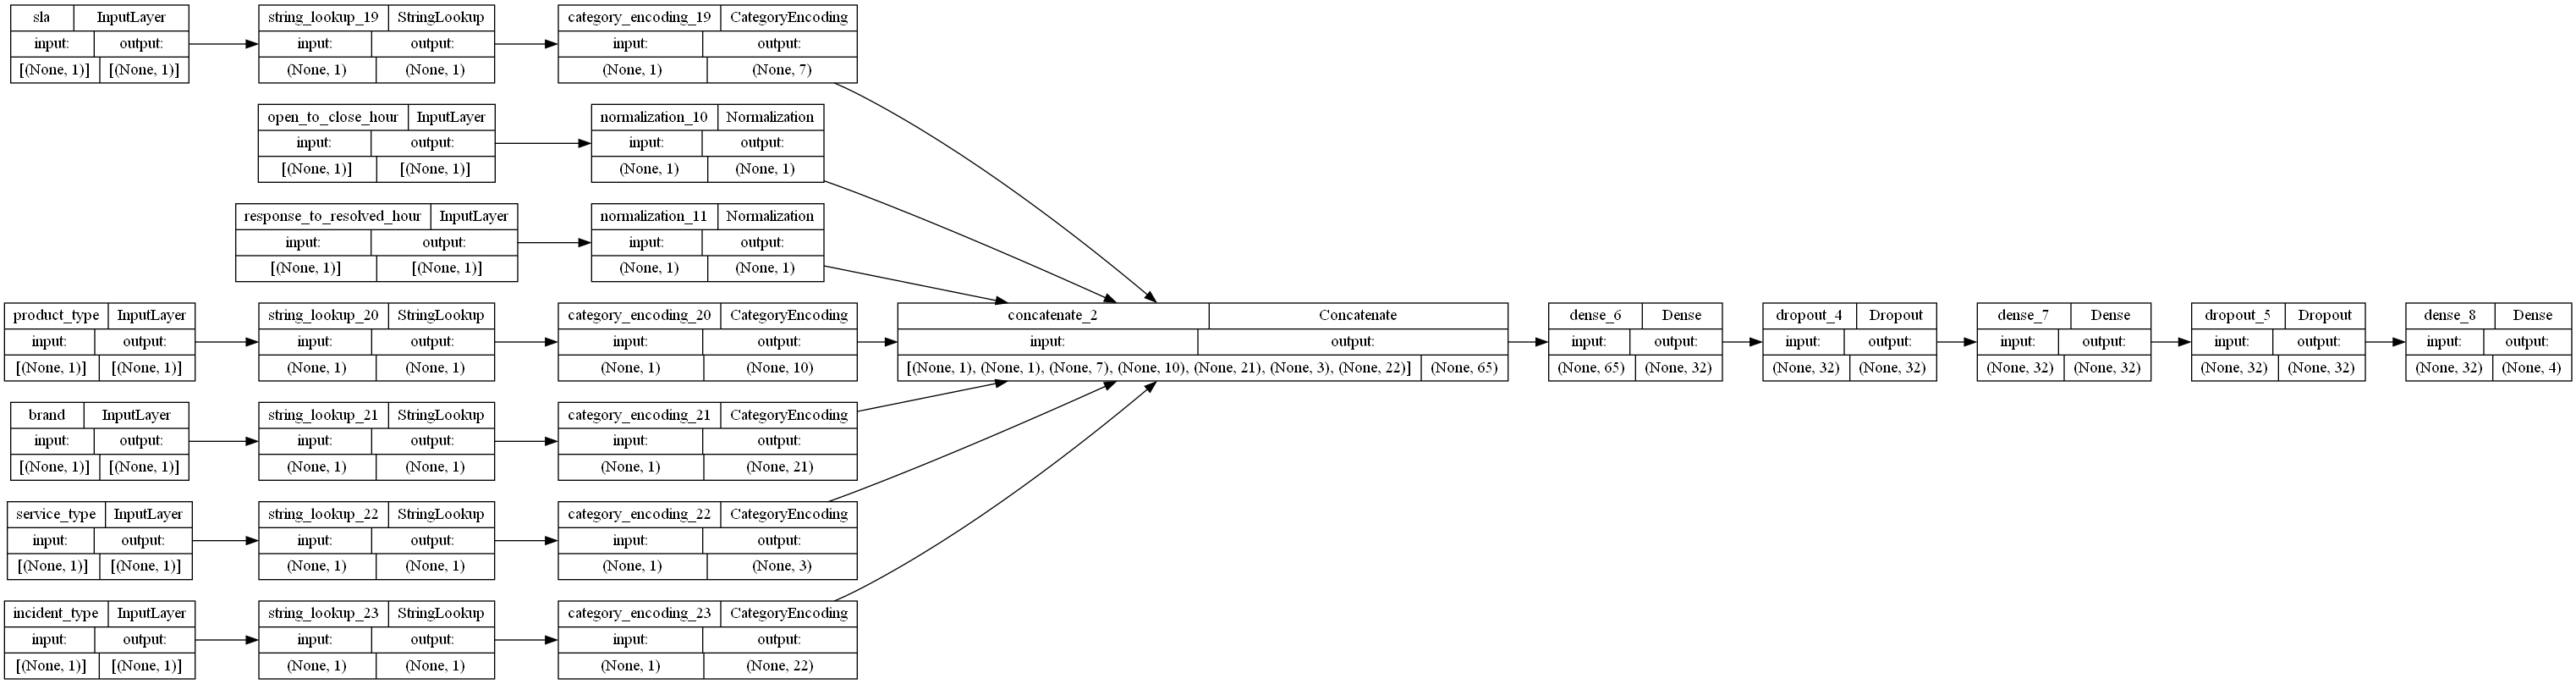

In [91]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [90]:
model.save(model_dir)


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [91]:
reloaded_model = tf.keras.models.load_model(model_dir)

In [92]:
#label_multi_severity
sample={"sla":"24x7 4Hrs Response Time",
        "product_type":"Server",
        "brand":"VMWare",                
        "service_type":"Incident",
        "incident_type":"General Incident",
        "open_to_close_hour":10,
        "response_to_resolved_hour":6.000000 \
       }

print(sample)
              
print("===============================================================================================================")    
print("convert pain data to serdor as input to predict")    
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
print(input_dict)

predictionList = reloaded_model.predict(input_dict)
print(predictionList)
prob = tf.nn.sigmoid(predictionList[0])
print(f"{(100 * prob)} %  as Severity")   

{'sla': '24x7 4Hrs Response Time', 'product_type': 'Server', 'brand': 'VMWare', 'service_type': 'Incident', 'incident_type': 'General Incident', 'open_to_close_hour': 10, 'response_to_resolved_hour': 6.0}
input t0 predict
{'sla': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'24x7 4Hrs Response Time'], dtype=object)>, 'product_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Server'], dtype=object)>, 'brand': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'VMWare'], dtype=object)>, 'service_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Incident'], dtype=object)>, 'incident_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'General Incident'], dtype=object)>, 'open_to_close_hour': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([10])>, 'response_to_resolved_hour': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.], dtype=float32)>}
1/1 [==============================] - 0s 455ms/step
[[0.0099079  0.11533944 0.8312779  0.04347473]]
[50.2

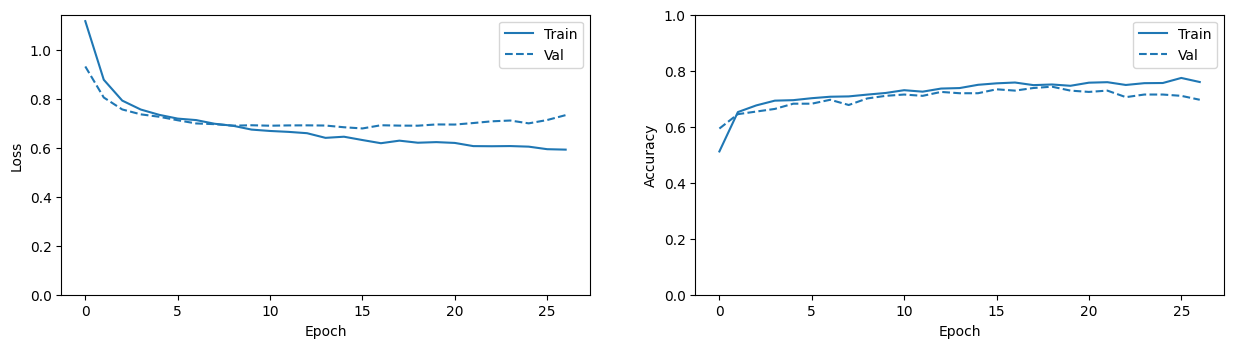

In [93]:
plt.figure(figsize=(15,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

# Copy Model From Local To GCS

In [94]:
#https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#6

GCP_PROJECT = 'pongthorn'
REGION = 'asia-southeast1'
MODEL_BUCKET = 'gs://tf1-incident-pongthorn'
MODEL_NAME = 'tf1_incident_multi_model'

# !gsutil mb -l $REGION $MODEL_BUCKET
# !gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/model

Copying file://.\model\saved_model.pb [Content-Type=application/octet-stream]...
Copying file://.\model\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
Copying file://.\model\fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://.\model\keras_metadata.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
Copying file://.\model\variables\variables.index [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
/ [1/5 files][ 97.0 KiB/527.8 KiB]  18% Done                                    
/ [2/5 files][ 97.0 KiB/527.8 KiB]  18% Done                          

# Import Model to Vertex AI

In [ ]:
# https://cloud.google.com/vertex-ai/docs/model-registry/import-model#get-operation

#https://codelabs.developers.google.com/vertex-p2p-predictions#3
# Import model manually
#https://console.cloud.google.com/vertex-ai/models?project=pongthorn
# Upload wand wait for vertex to complete process (Email notification)
# if run package ( you need to specify precuild-pacage


#Import model programactically
# https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers

# from google.cloud import aiplatform
# DEPLOY_IMAGE = "asia-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-6:latest"

# model = aip.Model.upload(
#     display_name="ponghthorn_xgb_" + TIMESTAMP,
#     artifact_uri=MODEL_DIR,
#     serving_container_image_uri=DEPLOY_IMAGE,
#     sync=False,
# )

# model.wait()


# Deploy Model to EndPoint

In [ ]:
#https://codelabs.developers.google.com/vertex-p2p-predictions#4
# Manual

# Program
# my_model = aiplatform.Model("projects/{PROJECT_NUMBER}/locations/us-central1/models/{MODEL_ID}") 

# endpoint = my_model.deploy(
#      deployed_model_display_name='my-endpoint',
#      traffic_split={"0": 100},
#      machine_type="n1-standard-4",
#      accelerator_count=0,
#      min_replica_count=1,
#      max_replica_count=1,
#    )

In [95]:
# Deploy to AIPlatform (Deprecated)
# MODEL = MODEL_NAME
# VERSION = 'v1'
# model_path = MODEL_BUCKET + '/model'

# # !gcloud ai-platform models create $MODEL --region=$REGION

# MACHINE_TYPE='n1-standard-2'

# !gcloud  ai-platform versions create $VERSION --model $MODEL --origin $model_path --runtime-version 2.11 --framework TENSORFLOW --machine-type $MACHINE_TYPE --python-version 3.7 --region=$REGION
# !gcloud ai-platform versions describe $VERSION --model $MODEL --region=$REGION